In [5]:
from keras.optimizers import *
from collections import defaultdict
import core.history as ch
import core.fine_model as cm
from core.fine_model import FineModel
from core import cam

import cr_interface as cri

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import pyplot as plt

import math
import os

## Load Model

In [6]:
models = FineModel.get_dict()
models.keys()
#dict_keys(['xception', 'mobileneta25', 'mobilenetv2a35', 'vgg16', 'resnet50v2',
#'inception_v3','inception_resnet_v2', 'densenet121', 'nasnet_mobile'])
fm = models['mobileneta25']()

## Load Weights

In [7]:
depth = 0
fm = models['mobileneta25']()
fm.get_model()
fm.load_weights('D{:02d}'.format(depth))
fm.compile_model()

Loading model mobileneta25... Loading model mobileneta25... complete!
Loading weights from /Users/itsnamgyu/code/cardiac-research/core/.fine_model_weights/mobileneta25/D00.hd5...complete!
Loading weights from /Users/itsnamgyu/code/cardiac-research/core/.fine_model_weights/mobileneta25/D00.hd5...complete!
complete!


## Visualized Grad-CAM Heatmap

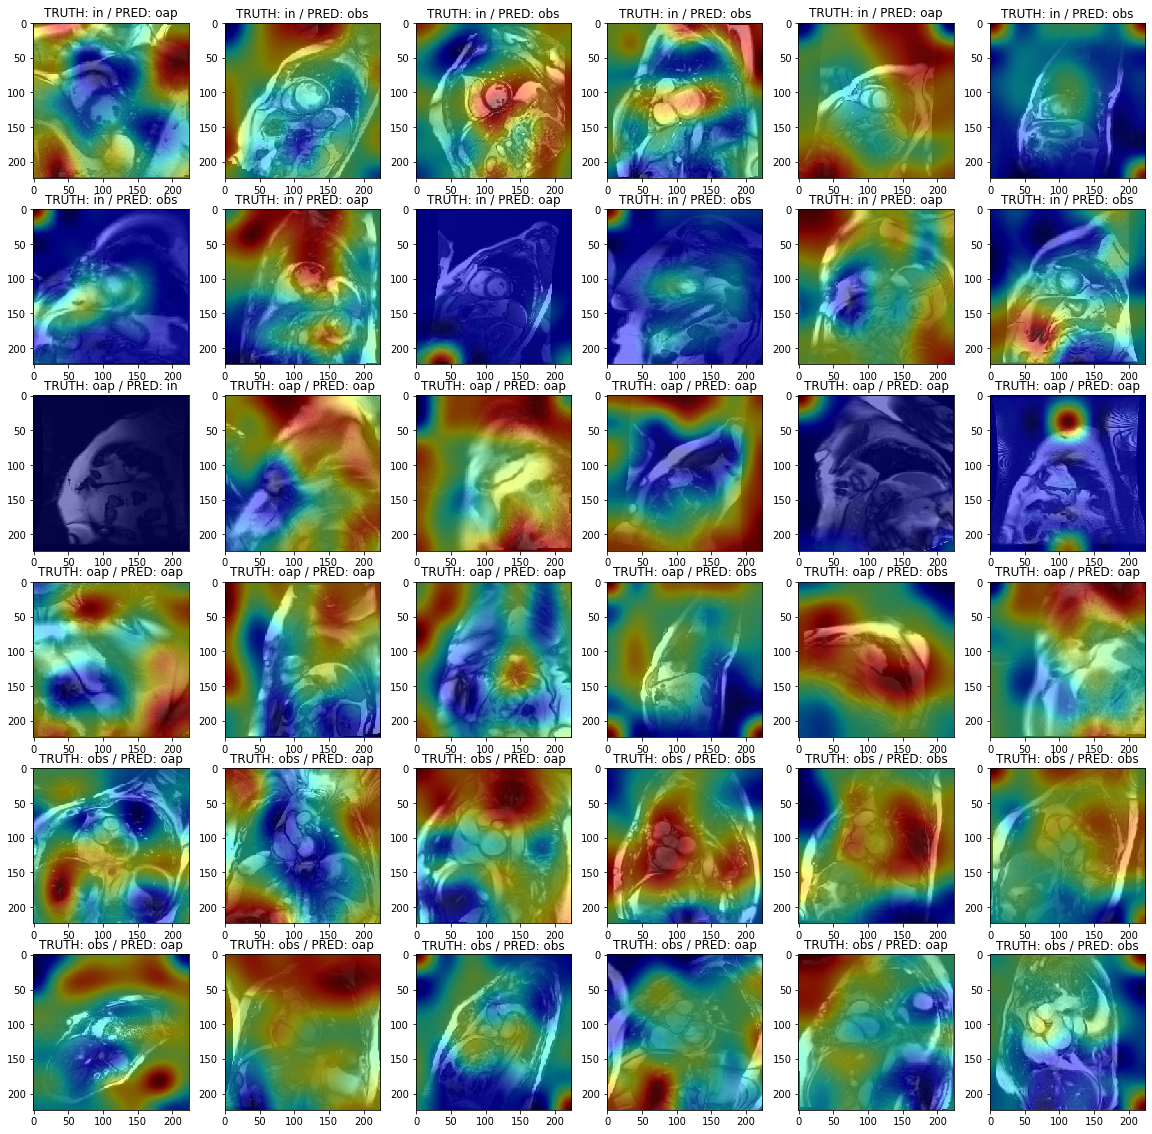

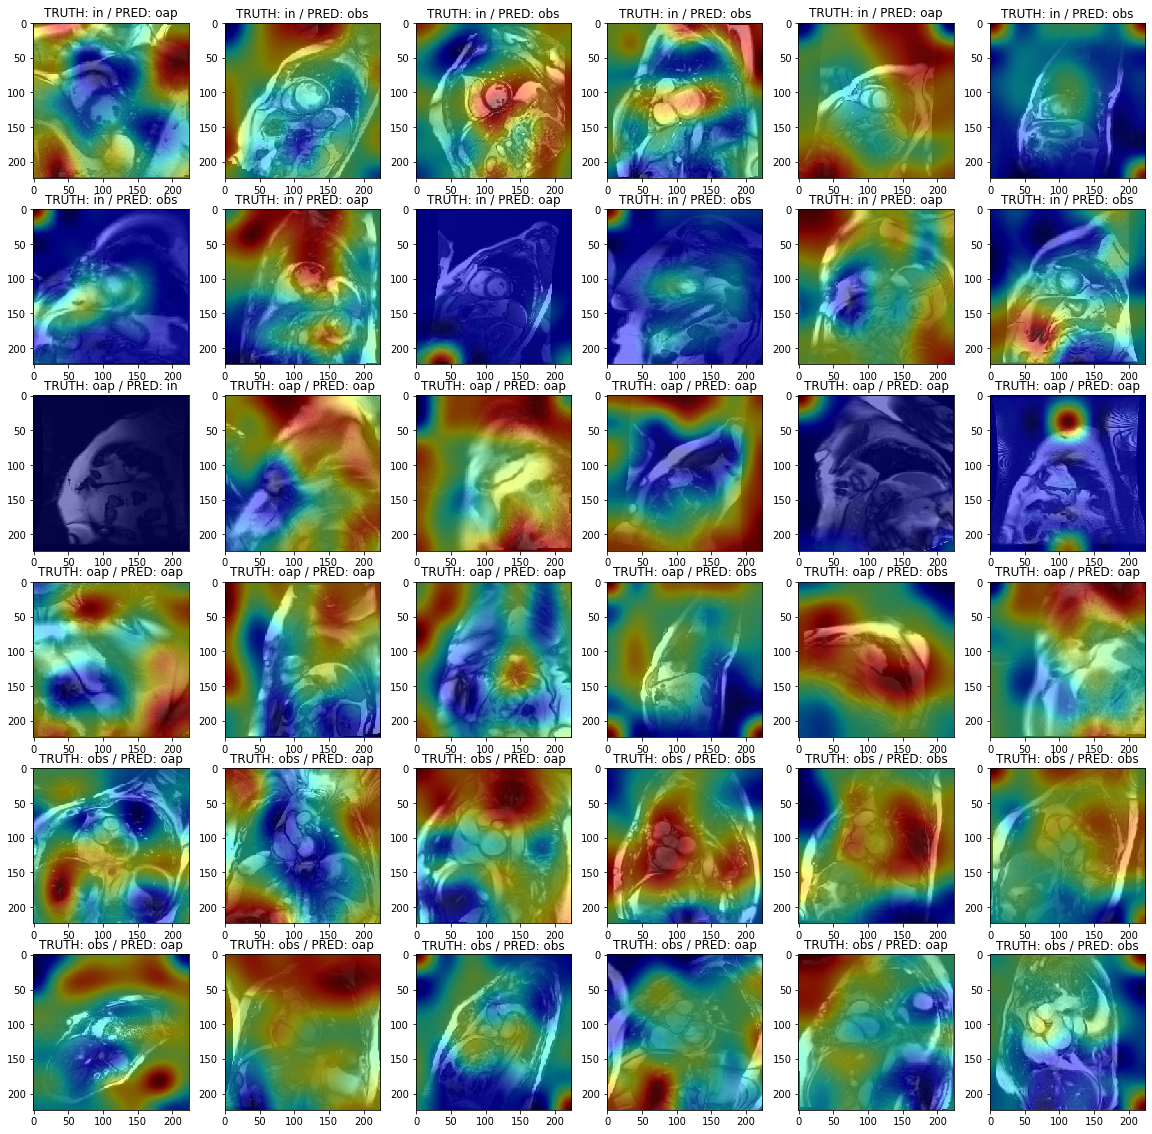

In [11]:
layer_idx = fm.depths[0]

f, ax = plt.subplots(6, 6, figsize=(20, 20))
ax = ax.flatten()

n_samples = 12
labels = ['in', 'oap', 'obs']

for label_index, label in enumerate(labels):
    # Filter dataset
    collection = cri.CrCollection.load()
    collection = collection.tri_label().filter_by(dataset_index=1, label=label)
    collection = collection.labeled().sample(n_samples)
    
    cr_codes = collection.get_cr_codes()
    images = collection.load_images(stack=True, target_size=fm.get_output_shape())
    
    dirname = 'heatmap_{}_{}'.format(fm.get_name(), label)
    
    for i, image in enumerate(images):
        cr_code = cr_codes[i]
        
        # Get prediction from model
        prediction_index = fm.predict(image)
        p_label = labels[prediction_index]
        
        # Get grad-cam overlayed image (for predicted class)
        heatmap_image = cam.overlay_gradcam(fm, image, class_index=prediction_index)
        
        # Display image
        ax[label_index * n_samples + i].imshow(heatmap_image)
        ax[label_index * n_samples + i].set_title('TRUTH: {} / PRED: {}'.format(label, p_label))
        
        # Save image
        os.makedirs(dirname, exist_ok=True)
        path = os.path.join(dirname, '{:02}_{}_{}.png'.format(i, label, cr_code))
        mpl.image.imsave(path, heatmap_image)
        path = os.path.join(dirname, '{:02}_{}_{}_original.png'.format(i, label, cr_code))
        mpl.image.imsave(path, image)